Script to plot maps of annual mean precipitation on SAFRAN moving sub-domains

In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from config import *
from functions import *
from utils import *
from make_acc_nep_SAFR import load_mat_SAFR_sub

R[write to console]: Le chargement a nécessité le package : kde1d



In [2]:
### CST ###

reg = 'Fr'
dataset = 'SAFRAN'
ymin = 1958
ymax = 2021
years = np.arange(ymin, ymax+1, 1)
per = str(ymin) + '-' + str(ymax)
yr = 1976
sizes = [10, 20, 30, 40, 50]  # sizes (domain side length, in number of pixels) to plot
prop = 0.33  # proportion du côté de la fenêtre sans recouvrement (dans les deux directions)
th_n = 0.75  # minimum proportion of land grid cell for the sub-domain to be considered
nbweeksmin = 4
nbweeksmax = 166  # 260
tss = [4, 26, 52, 104, 156]  # timescales (nb of weeks) to plot

projmap = ccrs.LambertConformal(central_longitude=2.337229, central_latitude=46.8, false_easting=600000., false_northing=2200000.)
resol = '50m'  # use data at this scale
bodr = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale=resol, facecolor='none', alpha=0.7)

In [3]:
#~ OUTDIR

if not os.path.isdir(FIGDIR + '/for_article'):
    os.mkdir(FIGDIR + '/for_article')
figdir = FIGDIR + '/for_article'

In [4]:
# Get France polygon and reprojectin SAFRAN CRS
cnydbffile = SHAPEDIR + '/world-boundaries/world-administrative-boundaries.dbf'
dfcny = gpd.read_file(cnydbffile)
dffra = gpd.GeoSeries(dfcny.iloc[93]['geometry'])
dffra.set_crs(dfcny.crs, inplace=True)
dffra_reproj = dffra.to_crs(proj)

In [5]:
ds = get_data_yr_SAFR(yr)

nyears = int(np.ceil(tss[-1] / 52))
years_ = np.arange(yr-nyears-1, yr+1, 1)


>>> 80x80 <<<


[84000, 156000] : [84000, 156000] : [108000, 180000] : [108000, 180000] : [108000, 180000] : [132000, 204000] : [132000, 204000] : [132000, 204000] : [132000, 204000] : [156000, 228000] : [156000, 228000] : [156000, 228000] : [156000, 228000] : [180000, 252000] : [180000, 252000] : [180000, 252000] : [180000, 252000] : [180000, 252000] : [204000, 276000] : [204000, 276000] : [204000, 276000] : [204000, 276000] : [204000, 276000] : [228000, 300000] : [228000, 300000] : [228000, 300000] : [228000, 300000] : [228000, 300000] : [228000, 300000] : [228000, 300000] : [252000, 324000] : [252000, 324000] : [252000, 324000] : [252000, 324000] : [252000, 324000] : [252000, 324000] : [252000, 324000] : [252000, 324000] : [252000, 324000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [276000, 348000] : [300000, 37200

'/home/guillaumechagnaud/TRAVAIL/POSTDOC/IGE-Secheresse/work/output/figures/for_article/fig5.png'

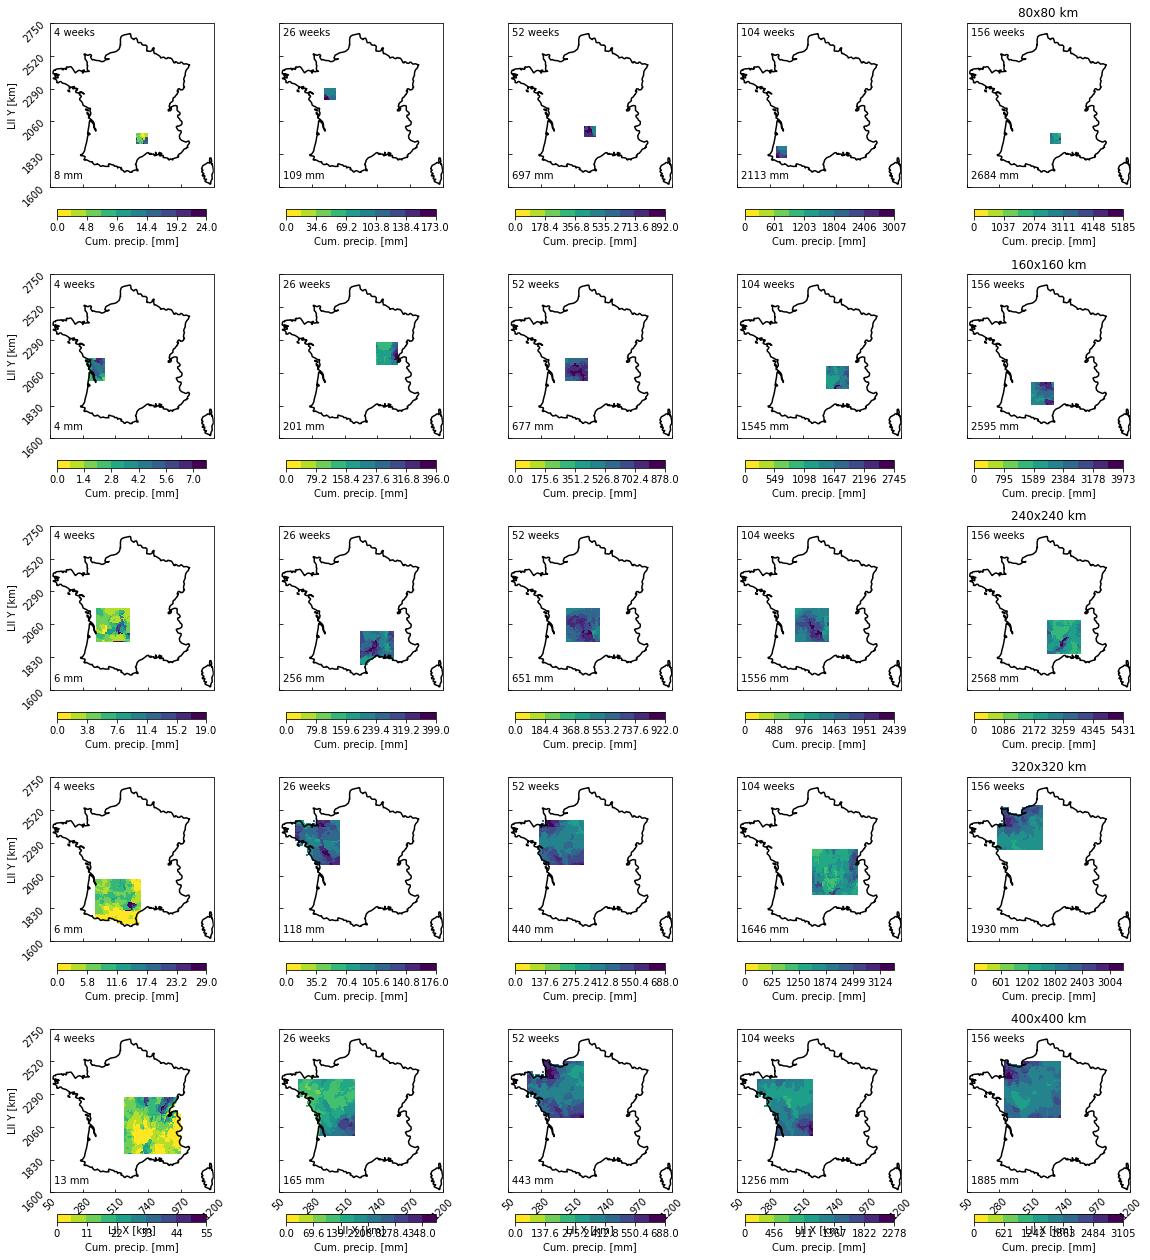

In [7]:
cmap_map = 'viridis_r'
cmap_map = plt.cm.get_cmap(cmap_map)

xlims = (50000., 1200000.)
ylims = (1600000., 2750000.)
xtcks = np.linspace(xlims[0], xlims[1], 6)
ytcks = np.linspace(ylims[0], ylims[1], 6)
xtlbs = [int(xt/1000) for xt in xtcks]
ytlbs = [int(yt/1000) for yt in ytcks]


fig, ax = plt.subplots(nrows=len(sizes), ncols=len(tss), figsize=(20., 20.), subplot_kw={'projection': projmap})

plt.subplots_adjust(bottom=0.1, top=0.95, wspace=0.15, hspace=0.15)

i=0
j=0

for size in sizes:
    size_ = str(int(size*res/1000)) + 'x' + str(int(size*res/1000))
    print('\n>>> {0} <<<'.format(size_))

    #print(i, j, end=' : ', flush=True)
    if j==ax.shape[1]:
        j=0
        i=i+1

    step = int(round(size * prop, 0))  # décalage dans la sélection des coordonnées des sous-fenêtres
    ntot = size **2  # total number of pixel within domain

    # Min and max coordinates (x, y) of the lower left pixel of sub-domains
    x_min_ = x_min
    x_max_ = x_max - size * res - res
    y_min_ = y_min
    y_max_ = y_max - size * res - res
    (x_min_, y_min_), (x_max_, y_max_)
    
    # Coordinates of the lower left pixel of all sub-domains
    xs = pd.Series(np.arange(x_min_, x_max_+res, res))  # all x coordinates
    ys = pd.Series(np.arange(y_min_, y_max_+res, res))  # all y coordinates

    # Sub-sample sub-domains coordinates (-> over-lapping)
    xs_ = xs[::step]
    ys_ = ys[::step]

    # Get all sub-domains lower left (ll) coordinates (x, y)
    ll_cells = []
    for x in xs_:
        for y in ys_:
            ll_cells.append((x, y))

    # Get annual cumulative precipitation of sub-domains with at least X % of land grid cell
    #cums = {}
    valid_cells = []

    for ll_cell in ll_cells:
        x_min_ = ll_cell[0]
        x_max_ = x_min_ + size * res - res
        y_min_ = ll_cell[1]
        y_max_ = y_min_ + size * res - res
        xs = [x_min_, x_max_]
        ys = [y_min_, y_max_]
        data = ds.sel(x=slice(xs[0], xs[1]), y=slice(ys[0], ys[1]))

        cum = data.mean(dim='time').product * len(data.indexes['time'])

        if len(cum.values[~np.isnan(cum.values)]) >= ntot*th_n:
            print(xs, end=' : ', flush=True)
            valid_cells.append((xs, ys))
            #cums[(x_min_, y_min_)] = cum

    for ts in tss:
        print(ts, end=' : ', flush=True)
        ax_ = ax[i][j]

        icell = np.random.randint(0, high=len(valid_cells))  # Get random cells (one for each timescale)
        cell = valid_cells[icell]

        x_center = cell[0][0] + size * res / 2
        y_center = cell[1][0] + size * res / 2
        #center = '({0},{1})'.format(int(round(x_center/1000, 0)), int(round(y_center/1000, 0)))

        mat = load_mat_SAFR_sub(reg, ymin, ymax, nbweeksmin, nbweeksmax, cell[0], cell[1], size)
        ygps = mat.groupby(mat.index.year).groups
        iyr = ygps[yr]
        mat_y = mat.loc[iyr][ts]

        dss = []

        for y in years_:
            dss.append(get_data_yr_SAFR(y, xs=cell[0], ys=cell[1]))

        dss = xr.concat(dss, dim='time')

        imin = np.where(dss.time == mat_y.index[mat_y.argmin()])[0][0]

        dss_ = dss.isel(time=slice(imin-24*7*ts-24, imin))

        cum_ = dss_.mean(dim='time').product * 3600 * len(dss_.indexes['time'])  # cumulative rainfall over n weeks before min
        cummax = np.ceil(cum_.max())

        ncols_map = np.arange(0, cummax+cummax/10, cummax/10)  # int(np.nanmax(cum))
        #ncols_map = [0., 400., 600., 800., 1000., 1200., 1400., 1600., 2000.]
        norm_map = BoundaryNorm(ncols_map, ncolors=cmap_map.N, clip=True)


        p = ax_.pcolor(cum_.indexes['x'], cum_.indexes['y'], cum_, norm=norm_map, cmap=cmap_map)
        ax_.text(0.025, 0.05, '{0} mm'.format(int(cum_.mean().values.round(0))), transform=ax_.transAxes)
        ax_.text(0.025, 0.92, '{0} weeks'.format(ts), transform=ax_.transAxes)

        #ax_.scatter(x_center, y_center, s=10, c='r', marker='x', zorder=100)

        dffra_reproj.boundary.plot(ax=ax_, color='k')

        ax_.set_xticks(xtcks)
        ax_.set_yticks(ytcks)
        ax_.tick_params(axis='x', direction='in')
        ax_.tick_params(axis='y', direction='in')

        if j == 0:
            ax_.set_yticklabels(ytlbs, rotation=45)
            ax_.set_ylabel('LII Y [km]')
        else:
            ax_.set_yticklabels([])
        if i == ax.shape[0]-1:
            ax_.set_xticklabels(xtlbs, rotation=45)
            ax_.set_xlabel('LII X [km]')
        else:
            ax_.set_xticklabels([])

        ax_.set_xlim(xlims)
        ax_.set_ylim(ylims)

        #ax_.add_feature(bodr, linestyle='--', edgecolor='k', alpha=1)  -> add feature on subplots ???
        #ax_.coastlines()  -> pb with shapely ??? (pip3 install shapely==1.8.2 -> change to former version?)
        #ax_.set_title(center)
        j=j+1

        fig.colorbar(p, ax=ax_, orientation='horizontal', label='Cum. precip. [mm]', shrink=0.75, pad=0.1)

    ax_.set_title('{0} km'.format(size_))


# Save

figfile = figdir + '/fig5.pdf'
fig.savefig(figfile)
figfile = figdir + '/fig5.png'
fig.savefig(figfile, dpi=400)
figfile

In [8]:
fig.savefig(figfile, dpi=400)